In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [21]:
def graph_real_estates(df, hue_column, vline=None):
    df["Date"] = pd.to_datetime(df["Date"])
    sns.set_theme()
    plt.figure(figsize=(14, 7))

    # Use hue to differentiate between multiple lines
    sns.lineplot(x="Date", y="Log Price", hue=hue_column, data=df, marker="o")

    if vline:
        plt.axvline(pd.to_datetime(vline), color="red", linestyle="--", label=f"Treatment: {vline}")

    plt.title("Log Price Trend Over Time")
    plt.xlabel("Year")
    plt.ylabel("Log_Price")
    plt.xticks(rotation=45)
    plt.legend(title=hue_column)
    plt.show()

def graph_labors(df, hue_column, vline=None):
    df["Year-Month"] = pd.to_datetime(df["Year-Month"])
    # sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.set_theme()
    sns.lineplot(x="Year-Month", y="Log Employment", hue=hue_column, data=df, marker="o")

    if vline:
        plt.axvline(pd.to_datetime(vline), color="red", linestyle="--", label=f"Treatment: {vline}")

    plt.title("Log Employment Over Time")
    plt.xlabel("Year")
    plt.ylabel("Log_Employment")
    plt.xticks(rotation=45)
    plt.legend(title=hue_column)
    plt.show()

In [4]:
# Fresno employment and real estate graphs
fresno_employment = pd.read_csv("./data/processed_employment/Fresno_County,_California.csv")
fresno_real_estate = pd.read_csv("./data/processed_zillow/Fresno_County.csv")

sc_employment = pd.read_csv(
    "./data/processed_employment/Santa_Clara_County,_California.csv"
)
sc_real_estate = pd.read_csv("./data/processed_zillow/Santa_Clara_County.csv")

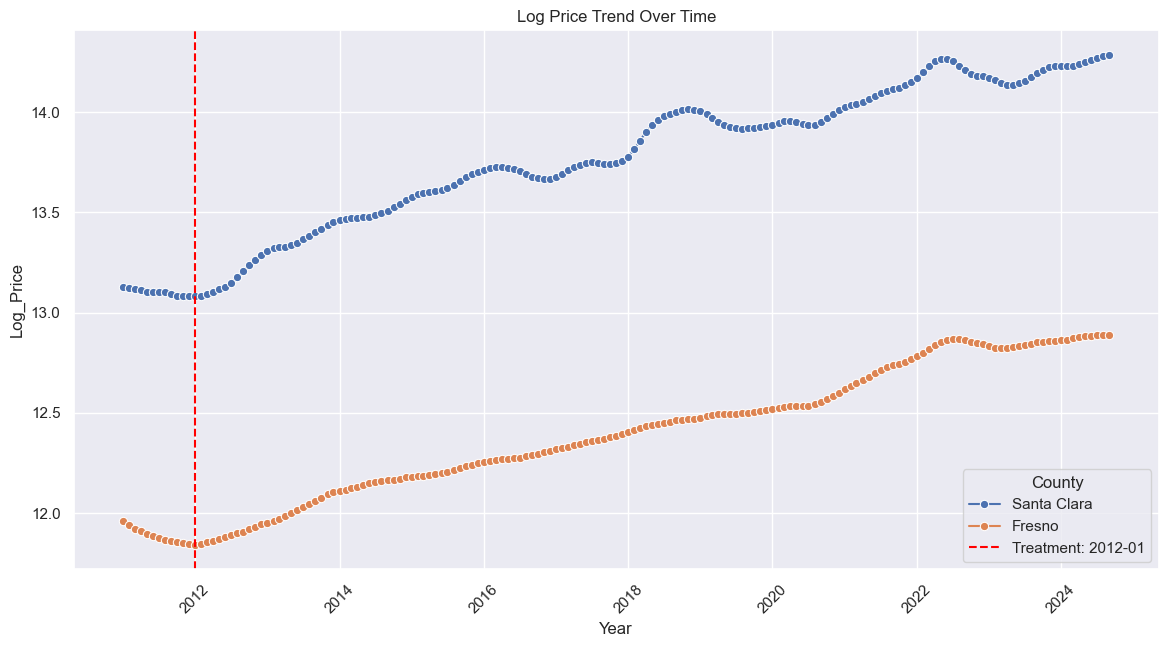

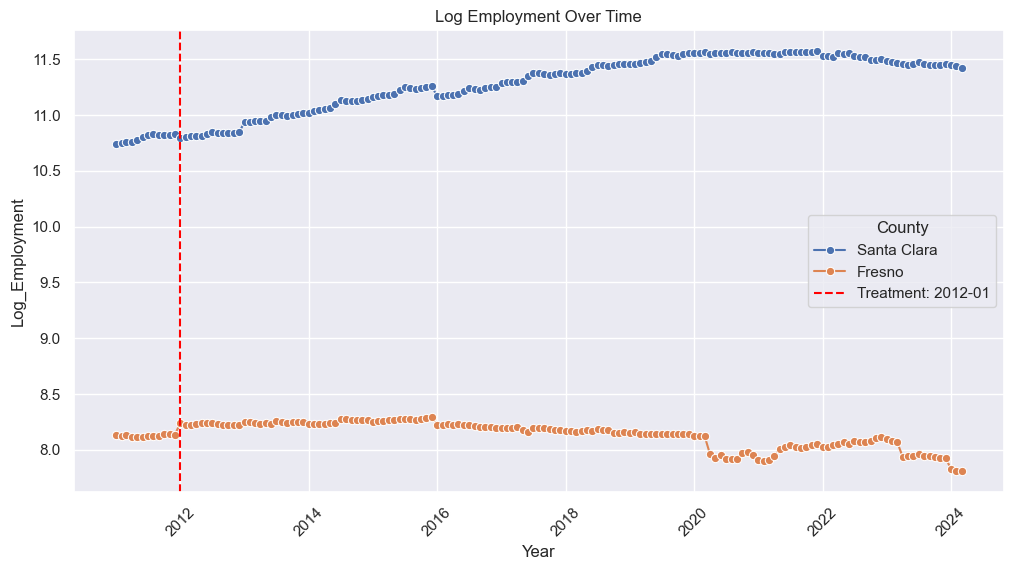

In [22]:
# SC vs SM

sc_real_estate["County"] = "Santa Clara"
sc_real_estate["Log_Price"] = sc_real_estate["Price"].apply(lambda x: np.log(x) if x > 0 else np.nan)

fresno_real_estate["County"] = "Fresno"
fresno_real_estate["Log_Price"] = fresno_real_estate["Price"].apply(lambda x: np.log(x) if x > 0 else np.nan)

sc_employment["County"] = "Santa Clara"
sc_employment["Log_Employment"] = sc_employment["Employment"].apply(lambda x: np.log(x) if x > 0 else np.nan)

fresno_employment["County"] = "Fresno"
fresno_employment.replace(0, pd.NA, inplace=True)
fresno_employment.fillna(fresno_employment["Employment"].mean(), inplace=True)
fresno_employment["Log_Employment"] = fresno_employment["Employment"].apply(lambda x: np.log(x) if x > 0 else np.nan)

sc_and_fresno_real_estate = pd.concat([sc_real_estate, fresno_real_estate], axis = 0)
sc_and_fresno_labors = pd.concat([sc_employment, fresno_employment], axis = 0)

graph_real_estates(sc_and_fresno_real_estate, "County", "2012-01")
graph_labors(sc_and_fresno_labors, "County", "2012-01")

In [28]:
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from statsmodels.stats.stattools import durbin_watson

sc_real_estate["county"] = "Santa Clara"
fresno_real_estate["county"] = "Fresno"

sc_real_estate["Date"] = pd.to_datetime(sc_real_estate["Date"])
fresno_real_estate["Date"] = pd.to_datetime(fresno_real_estate["Date"])

# Concatenate dataframes
data = pd.concat([sc_real_estate, fresno_real_estate])


data["treatment"] = data["county"].apply(lambda x: 1 if x == "Santa Clara" else 0)
# Define post variable based on intervention year, e.g., 2020
intervention_year = 2012
intervention_date = pd.to_datetime(f"{intervention_year}-01-01")
data["post"] = data["Date"].apply(lambda x: 1 if x >= intervention_date else 0)

# Interaction term for DiD
data["treatment_post"] = data["treatment"] * data["post"]
model = smf.ols(
    "Log_Price ~ treatment + post + treatment_post", data=data
).fit(cov_type='cluster', cov_kwds={'groups': data['county']})
print(model.summary())

stargazer = Stargazer([model])

# Set table options (optional)
stargazer.title("Regression Results")
stargazer.custom_columns(["OLS Regression"], [1])  # Custom header columns
stargazer.show_degrees_of_freedom(False)  # Optional: Hides degrees of freedom
# Calculate Durbin-Watson statistic
dw_stat = durbin_watson(model.resid)

# Add a custom note with the Durbin-Watson statistic
stargazer.add_custom_notes([f"Durbin-Watson: {dw_stat:.2f}"])

# Render the table in LaTeX format
latex_table = stargazer.render_latex()

# Print the LaTeX code (for copying into a LaTeX document)
print(latex_table)

                            OLS Regression Results                            
Dep. Variable:              Log_Price   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                -4.065e+39
Date:                Sun, 08 Dec 2024   Prob (F-statistic):               1.00
Time:                        13:40:38   Log-Likelihood:                -77.148
No. Observations:                 330   AIC:                             162.3
Df Residuals:                     326   BIC:                             177.5
Df Model:                           3                                         
Covariance Type:              cluster                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         11.8894   4.29e-14   2.77e